<h1 style="text-align: center;"><b>Longstaff-Schwarz/Least-Squares Method</b></h1>

#### Maksim Sosnin - MIPT


Let $S$ be the price of the underlying, $V_t(S)$ – option value, $\Psi(S)$ – payoff, $T$ – maturity, $r$ – risk-free rate.

We can approximate American option with a Bermudan option, which can be exercised at specified discrete dates:
$$\Delta t := \frac{T}{M},\quad t_j := j \Delta t\ (j = 0, ..., M),$$
where $T$ is maturity, $M$ – number of time steps.

### Dynamic programming
$V_{t_M}(S) = \Psi(S)\ $ – payoff.

$C_{t_n}(S) := e^{-r \Delta t}\ \mathbb{E}[V_{t_{n+1}}(S_{t_{n+1}}) | S_{t_n} = S]\ $ – continuation or holding value. Needs to be approximated, e.g. by regression.

$V_{t_n}(S) = \max[C_{t_n}(S), \Psi(S)].$

### LSM algorithm (Monte-Carlo + Regression)
1. Simulate $N$ paths $S_1(t), ... , S_N(t)$ with $M$ time steps:
    $$S_{j,k} := S_k(t_j),\quad j = 1, ..., M,\ k = 1, ..., N.$$
2. For $k = 1, ..., N$ set
    - $g_k := \Psi(S_{M,k})$ – cashflow vector,
    - $\tau_k = M$ – integer stopping time vector.
3. For $j = M - 1, ..., 1$:
    For the subset of in-the-money points $(x_k, y_k) := (S_{j,k}, e^{-r(\tau_k-j)\Delta t} g_k)$:
    - Approximate $C_j(x)$ using suitable basis functions $\phi_0, ..., \phi_L$ (for example, monomials) by least squares over the ITM points:
        $$C_j(x) \approx \sum_{l=0}^L a_l \phi_l(x) =: \hat C_j(x).$$
    - For those $k$ with $\Psi(S_{j,k}) \geq \hat C_j(S_{j,k})$ update
        $$g_k := \Psi(S_{j,k}),\quad \tau_k := j.$$
4. Finally, set
    $$\hat C_0 := \frac{1}{N} \sum_{k=1}{N} e^{-r\tau_k \Delta t} g_k, \quad V_0 := \max\{\Psi(S_0), \hat C_0\}.$$


For more in-depth explanation of LSM algorithm, see [Seydel2017, section 3.6.3] and the original article [LongstaffSchwartz2001].

In [1]:
import torch
import numpy as np
from torch.utils.cpp_extension import load
import matplotlib.pyplot as plt

torch.set_default_tensor_type(torch.DoubleTensor)

!mkdir -p build
NOA_LOCATION = '../..'

In [2]:
n_paths = 100_000
n_steps = 250
dt = 1/250

sigma = 0.3
S0 = 100
strike = S0 * 0.85
rate = 0.03

In [3]:
def generate_gbm(n_paths, n_steps, dt, S0, sigma, drift):
    paths_gbm = S0 * torch.cumprod(
        1 + drift*dt + sigma * (dt**0.5) * torch.randn((n_paths, n_steps)), dim=1)
    paths_gbm = torch.hstack((S0 * torch.ones((n_paths, 1)), paths_gbm))
    return paths_gbm

In [4]:
paths_gbm = generate_gbm(n_paths, n_steps, dt, S0, sigma, rate)

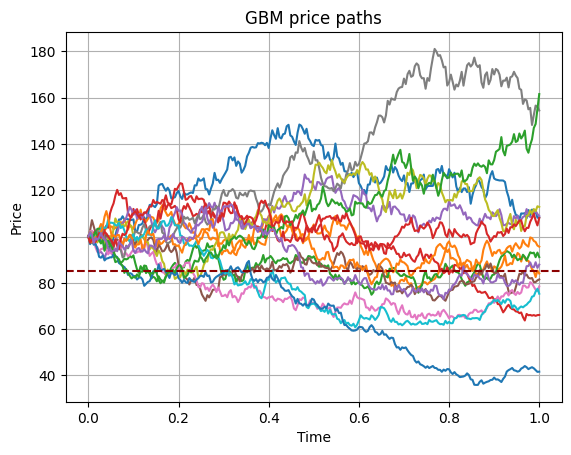

In [5]:
time_arr = np.linspace(0, n_steps*dt, n_steps+1)
for i in range(15):
    plt.plot(time_arr, paths_gbm.detach().numpy()[i])
plt.axhline(strike, ls='--', label='Strike', c='darkred')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('GBM price paths')
plt.grid()
plt.show()

# LSM algorithm implementation

In [6]:
POLY_DEGREE = 3
cashflow = torch.where(paths_gbm[:, -1] < strike, strike - paths_gbm[:, -1], 0)
tau = n_steps * torch.ones(n_paths, dtype=torch.int64)

####### Only for visualization #######
C_hats = [None] * (n_steps+1)
paths_itm_vals = [None] * (n_steps+1)
y_vals = [None] * (n_steps+1)
######################################

for j in range(n_steps - 1, 0, -1):
    itm_mask = paths_gbm[:, j] < strike
    paths_itm = paths_gbm[:, j][itm_mask]

    A = torch.vander(paths_itm, N=POLY_DEGREE + 1)
    y = torch.exp(-rate * (tau[itm_mask] - j) * dt) * cashflow[itm_mask]
    fit_params = torch.linalg.lstsq(A, y).solution
    C_hat = torch.matmul(A, fit_params)

    ####### Only for visualization #######
    C_hats[j] = C_hat
    paths_itm_vals[j] = paths_itm
    y_vals[j] = y
    ######################################

    payoff_itm_now = strike - paths_itm
    stop_now_mask = (payoff_itm_now >= C_hat)
    cashflow[itm_mask] = torch.where(stop_now_mask, payoff_itm_now, cashflow[itm_mask])
    tau[itm_mask] = torch.where(stop_now_mask, j, tau[itm_mask])

C_hat = torch.mean(torch.exp(-rate * tau * dt) * cashflow).item()
option_price = max(strike - S0, C_hat)

In [7]:
print(f'Price of American put: {option_price}')

Price of American put: 4.305067756607265


In [8]:
def visualize_lsm(idx):
    itm_index = paths_gbm[:, idx] < strike
    C_hat = C_hats[idx]

    plt.figure(figsize=(9, 6))
    plt.scatter(paths_itm_vals[idx], y_vals[idx], s=.5, label='ITM points $(x_k, y_k)$')
    plt.scatter(paths_gbm[:, idx][itm_index], C_hat, s=2, label='Continuation value $\hat C_j(x)$')

    S_space = np.linspace(min(paths_gbm[:, idx]).item() - 7, max(paths_gbm[:, idx]).item() + 7, 1000)
    payoff = np.maximum(strike - S_space, 0)
    plt.plot(S_space, payoff, color='black', label='Payoff $\Psi(S)$', lw=2)
    plt.axvline(strike, ls='--', label='Strike', c='darkred', lw=1)

    plt.xlim(min(S_space), 120)
    plt.ylim(-7, max(payoff) + 7)
    plt.xlabel('S')
    plt.title(f'j = {idx}, n_steps = {n_steps}')
    plt.legend()
    plt.show()

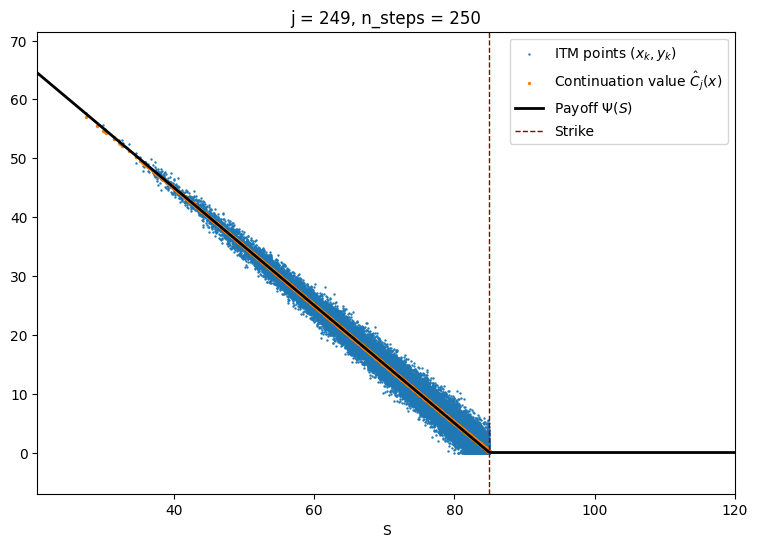

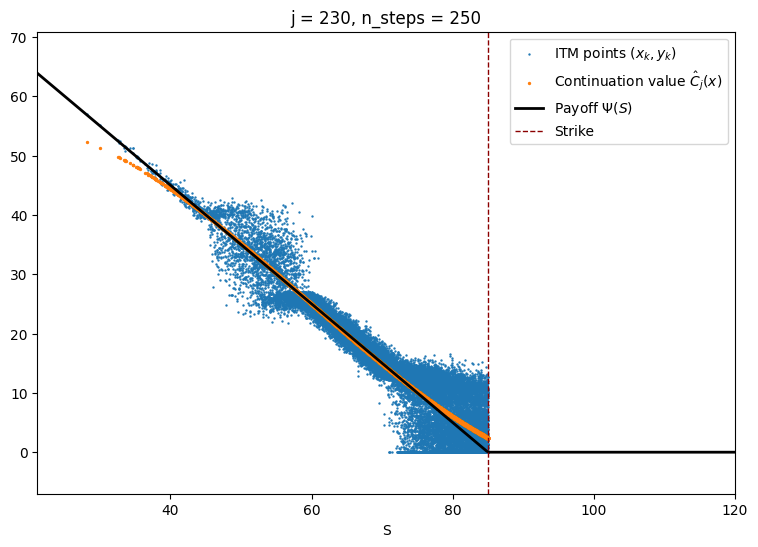

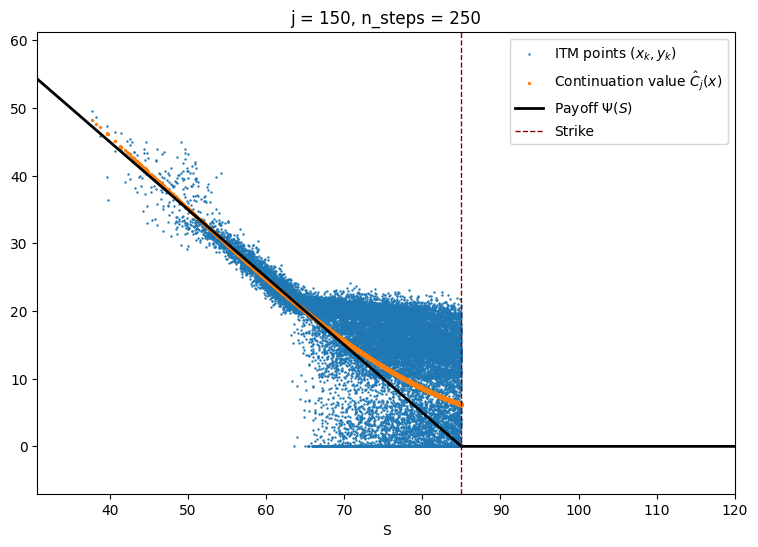

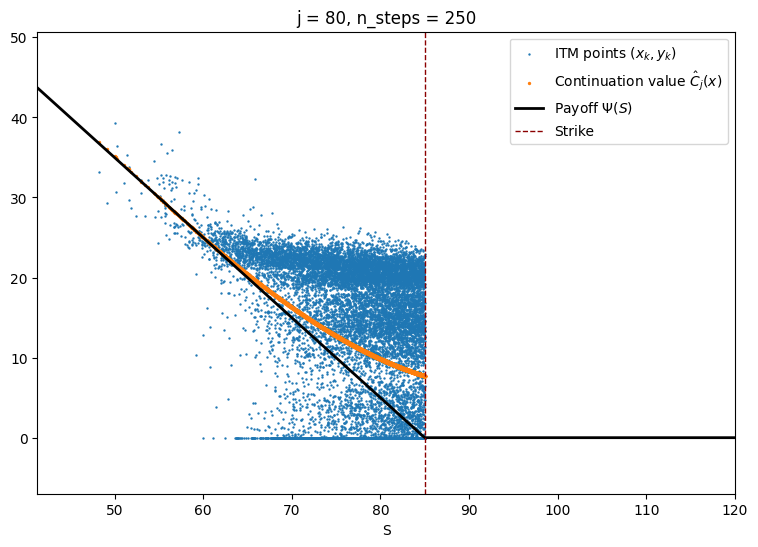

In [9]:
visualize_lsm(n_steps - 1)
visualize_lsm(n_steps - 20)
visualize_lsm(n_steps - 100)
visualize_lsm(n_steps - 170)

# Comparison with Brennan-Schwartz algorithm

For GBM underlying, we can compare the price obtained via LSM and Brennan-Schwartz algorithms (see [bsm.ipynb](bsm.ipynb)).

In [10]:
n_paths = 1_000_000

In [11]:
bsm = load(
    name='bsm',
    build_directory='./build',
    sources=[f'{NOA_LOCATION}/docs/quant/bsm.cc'],
    extra_include_paths=[f'{NOA_LOCATION}/src'],
    extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
    verbose=False
)

lsm = load(
    name='lsm',
    build_directory='./build',
    sources=[f'{NOA_LOCATION}/docs/quant/lsm.cc'],
    extra_include_paths=[f'{NOA_LOCATION}/src'],
    extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
    verbose=False
)

In [12]:
paths_gbm = generate_gbm(n_paths, n_steps, dt, S0, sigma, rate)
price_lsm_gbm = lsm.price_american_put_lsm(paths_gbm, dt, strike, rate)

In [13]:
T = n_steps*dt
S_min = 30
S_max = 200
npoints_S = 3000
npoints_t = 3000

V_bsm, S_arr, t_arr = bsm.price_american_put_bs(
    strike, T, rate, sigma, S_min, S_max, npoints_S, npoints_t)

price_american_put_bs(): delta_tau / (delta_x)^2 = 37.4972


In [14]:
price_bsm = V_bsm[np.argmin(np.abs(S_arr - S0)), -1]
rel_diff = (price_lsm_gbm - price_bsm) / price_bsm

In [15]:
print(f'LSM price: {price_lsm_gbm}')
print(f'Brennan-Schwartz price: {price_bsm}')
print(f'Relative difference: {rel_diff * 100}%')

LSM price: 4.341391956835366
Brennan-Schwartz price: 4.35758812877759
Relative difference: -0.37167743861022756%


The prices are close.

# Pricing of American put option under the Heston model

In [16]:
heston = load(
    name='heston',
    build_directory='./build',
    sources=[f'{NOA_LOCATION}/docs/quant/heston.cc'],
    extra_include_paths=[f'{NOA_LOCATION}/src'],
    extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
    verbose=False
)

To make the pricing results comparable, let's set the initial variance $v_0$ and long-run variance $\theta$ equal to the variance of GBM. Also let's make reversion parameter $\kappa$ large and volatility of variance $\varepsilon$ low.

In [17]:
kappa = 2
theta = sigma**2
eps = 0.1
rho = -0.65
v0 = theta

In [18]:
init_state_price = S0 * torch.ones(n_paths, dtype=torch.double)
init_state_var = v0 * torch.ones(n_paths, dtype=torch.double)
paths_heston, paths_heston_var = heston.generate_heston(
    n_paths, n_steps, dt, init_state_price, init_state_var, kappa, theta, eps, rho, rate)

In [19]:
price_lsm_heston = lsm.price_american_put_lsm(paths_heston, dt, strike, rate)
diff_heston_gbm = (price_lsm_heston - price_lsm_gbm) / price_lsm_gbm

In [20]:
print(f'LSM price with Heston model: {price_lsm_heston}')
print(f'Relative difference between GBM model: {diff_heston_gbm*100}%')

LSM price with Heston model: 4.461945615364168
Relative difference between GBM model: 2.7768434577530825%


We can see that under the Heston model, even with our choice of parameters, LSM algorithm produces higher price than under the GBM model. This is because of stochastic volatility.

# References

- [LongstaffSchwartz2001] [Longstaff, F. A., & Schwartz, E. S. (2001). Valuing American options by simulation: a simple least-squares approach. The review of financial studies, 14(1), 113-147.](http://deriscope.com/docs/Longstaff_Schwarz_2001.pdf)
- [Seydel2017] [Seydel, Rüdiger. Tools for computational finance. Sixth edition. Springer, 2017.](https://link.springer.com/book/10.1007/978-1-4471-7338-0) Section 3.6.3.
- [Huge2017] [Huge, B. N., & Savine, A. (2017). LSM Reloaded-Differentiate xVA on your iPad Mini. Available at SSRN 2966155.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2966155)
- [Jonen2011] [Jonen, C. (2011). Efficient pricing of high-dimensional American-style derivatives: A robust regression Monte Carlo method (Doctoral dissertation, Universität zu Köln).](https://kups.ub.uni-koeln.de/4442/1/Diss_Jonen.pdf)
